In [1]:
# Mount Google Drive to access your saved model
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/egemenokte/3DLayeredElastic.git
%cd 3DLayeredElastic/Run
import sys
import os
sys.path.append('..')
from Main.MLEV_Parallel import PyMastic
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import random

import sys
import os


Cloning into '3DLayeredElastic'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 134 (delta 23), reused 0 (delta 0), pack-reused 86 (from 1)
Receiving objects: 100% (134/134), 2.97 MiB | 4.94 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/3DLayeredElastic/Run


In [5]:
import pickle
import torch
import json
import time
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
import torch
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import seaborn as sns
import torch.nn as nn
import copy
from torch import nn

from torch.nn import Linear, ReLU,Tanh
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

In [6]:
# Read dictionary pkl file
with open('/content/drive/MyDrive/GAT_LET_Analysis/dataset/Frame_data_1000_new_modified.pkl', 'rb') as fp:
    FrameLarge = pickle.load(fp)
with open('/content/drive/MyDrive/GAT_LET_Analysis/dataset/Section_data_1000_new_modified.pkl', 'rb') as fp:
    Section = pickle.load(fp)

In [7]:
Nmaterial=3#maximum number of materials (AC, base, subbase, subgrade)
MaterialType=['AC','B','SG'] #AC, base, subbase, subgrade
Sublayermax=[1,1,1] #each material can have up to 5 sublayers, excluding subgrade

#################May need to change
# Thicknessrange=[[2,20],[4,40],[4,40]] #thickness range in inches
# Modulusrange=[[200,2000],[20,300],[20,300],[5,50]] #modulus range in ksi

Thicknessrange=[[2,20],[4,40]] #thickness range in inches
Modulusrange=[[500,2000],[50,300],[5,50]] #modulus range in ksi
N=1000 #Number of points
zpoints=14 #how many points to generate along z
xpoints=10 #how many points to generate along x
seed=42
############################


Thicknessincrement=[1,2,4]
ModulusIncrement=[50,20,20,5]# increment in modulus sampling
# nurange=[[0,0.499],[0.15,0.499],[0.15,0.499],[0.15,0.499],[0.4,0.499]] #poissons ratio
# nurange=[[0.3,0.4],[0.2,0.499],[0.2,0.499],[0.2,0.499],[0.2,0.499]] #poissons ratio
nurange=[[0.3,0.4],[0.2,0.499],[0.2,0.499]] #poissons ratio
#xmax=40 #40 inches away from the load
#rmax=80 #80 inches away from the load
#LoadRange=[1000,20000] #pounds of force applied
arange=[3,9] #contact radius (in)
arange=[4,4] #contact radius (in)

apoints=2 #how many contact radii to analyze
apoints=1 #how many contact radii to analyze
factor=0.4
filter = 2
split_idx=800
test_idx=900


In [ ]:

Length= FrameLarge["Structure"].unique()

for structure in Length:
    struct = int(structure) - 1

    filtered = FrameLarge[FrameLarge["Structure"] == structure]

    inp = filtered.loc[:, ["Strain_Z"]] * 1e6

    # Check if any Strain_Z value is greater than 2000
    if (inp['Strain_Z'] >=1500).any():

        FrameLarge = FrameLarge[FrameLarge["Structure"] != structure]
        print(struct)
        continue


111
215
223
335
352
633
658
663
898
992


In [ ]:
Length= FrameLarge["Structure"].unique()


In [ ]:
Length[test_idx:]

array([ 910.,  911.,  912.,  913.,  914.,  915.,  916.,  917.,  918.,
        919.,  920.,  921.,  922.,  923.,  924.,  925.,  926.,  927.,
        928.,  929.,  930.,  931.,  932.,  933.,  934.,  935.,  936.,
        937.,  938.,  939.,  940.,  941.,  942.,  943.,  944.,  945.,
        946.,  947.,  948.,  949.,  950.,  951.,  952.,  953.,  954.,
        955.,  956.,  957.,  958.,  959.,  960.,  961.,  962.,  963.,
        964.,  965.,  966.,  967.,  968.,  969.,  970.,  971.,  972.,
        973.,  974.,  975.,  976.,  977.,  978.,  979.,  980.,  981.,
        982.,  983.,  984.,  985.,  986.,  987.,  988.,  989.,  990.,
        991.,  992.,  994.,  995.,  996.,  997.,  998.,  999., 1000.])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train,y_train=FrameLarge.iloc[:135520,3:13],FrameLarge.iloc[:135520,19:22]
x_val,y_val = FrameLarge.iloc[135520:152720,3:13],FrameLarge.iloc[135520:152720,19:22]
# X_train,X_test,y_train,Y_test = train_test_split(FrameLarge.iloc[:,3:13],FrameLarge.iloc[:,19:20], test_size=0.1, random_state=42)
X_test, Y_test = FrameLarge.iloc[152720:169799,3:13], FrameLarge.iloc[152720:169799,19:22]
scaler = StandardScaler()
scalery = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(X_test)
x_val=scaler.transform(x_val)
y_train=scalery.fit_transform(y_train)
y_val=scalery.transform(y_val)

y_test=scalery.transform(Y_test)

print(y_val.min(), y_val.max())

-5.839728435373476 10.101204249752342


In [ ]:
# Assuming x_train and y_train are NumPy arrays
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# # Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
x_train.shape

(135520, 10)

In [ ]:
# Define the model class
class MyModel(nn.Module):
    def __init__(self, input_size, l1_lambda=1e-5):
        super(MyModel, self).__init__()
        self.l1_lambda = l1_lambda
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 3)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.fc5(x)
        return x

    def l1_regularization(self):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return self.l1_lambda * l1_norm

In [ ]:
# Instantiate the model
input_size = x_train.shape[1]
model = MyModel(input_size)

In [ ]:
path = '/content/drive/MyDrive/GAT_LET_Analysis/pickle/model.pth'


In [ ]:
model.load_state_dict(torch.load(path))

# Set the model to evaluation mode (optional if you are only evaluating the model)
model.eval()

MyModel(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=3, bias=True)
  (act): ReLU()
)

In [ ]:
model.eval()
device = torch.device('cpu')
model.to(device)  # Move the model to CPU

# Ensure the input
# s are also on the CPU
test_inputs = x_test
# Forward pass to get predictions
with torch.no_grad():
    test_inputs = torch.tensor(x_test,dtype=torch.float32)


test_outputs = model(test_inputs)


# Convert predictions to numpy array
predicted_values = test_outputs.detach().numpy()

In [ ]:
y_pred=scalery.inverse_transform(predicted_values)
y_plot=scalery.inverse_transform(y_test)


In [ ]:
final_y_plot = y_plot*1e6
final_y_pred = y_pred*1e6

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error


In [ ]:
mse_z = mean_squared_error( final_y_plot[:, 0], final_y_pred[:, 0])
mse_r = mean_squared_error( final_y_plot[:, 1], final_y_pred[:, 1])
mse_t = mean_squared_error(  final_y_plot[:, 2], final_y_pred[:, 2])
mae_z = mean_absolute_error( final_y_plot[:, 0], final_y_pred[:, 0])
mae_r = mean_absolute_error(final_y_plot[:, 1], final_y_pred[:, 1])
mae_t = mean_absolute_error(final_y_plot[:, 2], final_y_pred[:, 2])


In [ ]:
mae_r

0.9372502983024377

In [ ]:

with open('/content/drive/MyDrive/GAT_LET_Analysis/training/ZS_test', 'rb') as fp:
    ZS_new = pickle.load(fp)

In [ ]:

with open('/content/drive/MyDrive/GAT_LET_Analysis/training/xs', 'rb') as fp:
    xs = pickle.load(fp)

In [ ]:
import pickle
with open('/content/drive/MyDrive/GAT_LET_Analysis/evaluation/batched_graph_test.pkl', 'rb') as fp:
    batched_graph_test = pickle.load(fp)

In [ ]:
xs_converted= xs*2.54
ZS_converted = [i*2.54 for i in ZS_new]

In [ ]:
xs=np.round(xs_converted,2)
ZS_new=[np.round(zs,2) for zs in ZS_converted]

In [ ]:
pred_graph ={}
current_index = 0
for i in range(batched_graph_test.batch_size):
    res_test= len(batched_graph_test[i].y)

    pred_values = final_y_pred[current_index:current_index+res_test]

    pred_graph[i]=pred_values
    current_index+=res_test



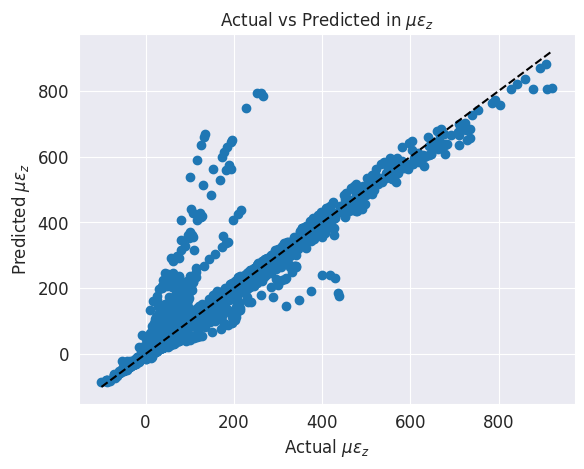

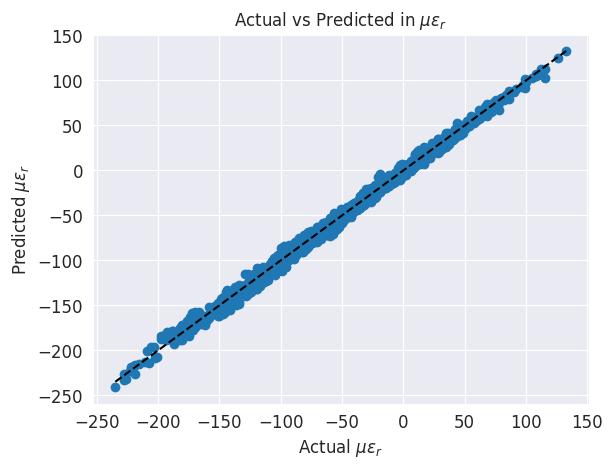

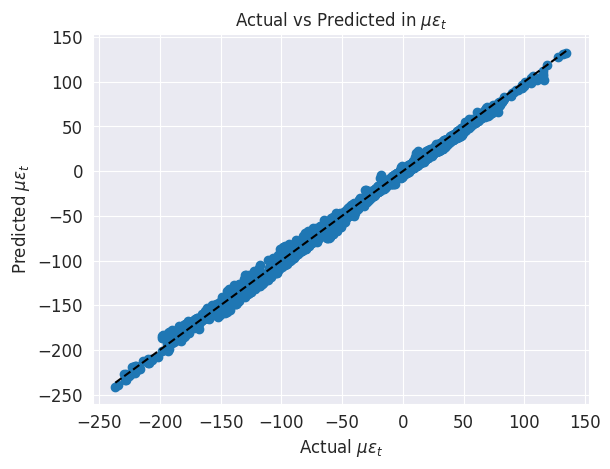

In [ ]:

sns.set_style("darkgrid")

stress_z = final_y_plot[:, 0]

plt.scatter(stress_z, final_y_pred[:, 0])
p1= max(max(stress_z), max(stress_z))
p2=min(min(stress_z), min(stress_z))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_z$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_z$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_z$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
plt.close()


stress_r =  final_y_plot[:, 1]
plt.scatter(stress_r, final_y_pred[:, 1])
p1= max(max(stress_r), max(stress_r))
p2=min(min(stress_r), min(stress_r))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_r$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_r$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_r$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
plt.close()

stress_t =final_y_plot[:, 2]
plt.scatter(stress_t,  final_y_pred[:, 2])
p1= max(max(stress_t), max(stress_t))
p2=min(min(stress_t), min(stress_t))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_t$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_t$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_t$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
plt.close()

In [ ]:
test_struct=0
test_g_struct=0



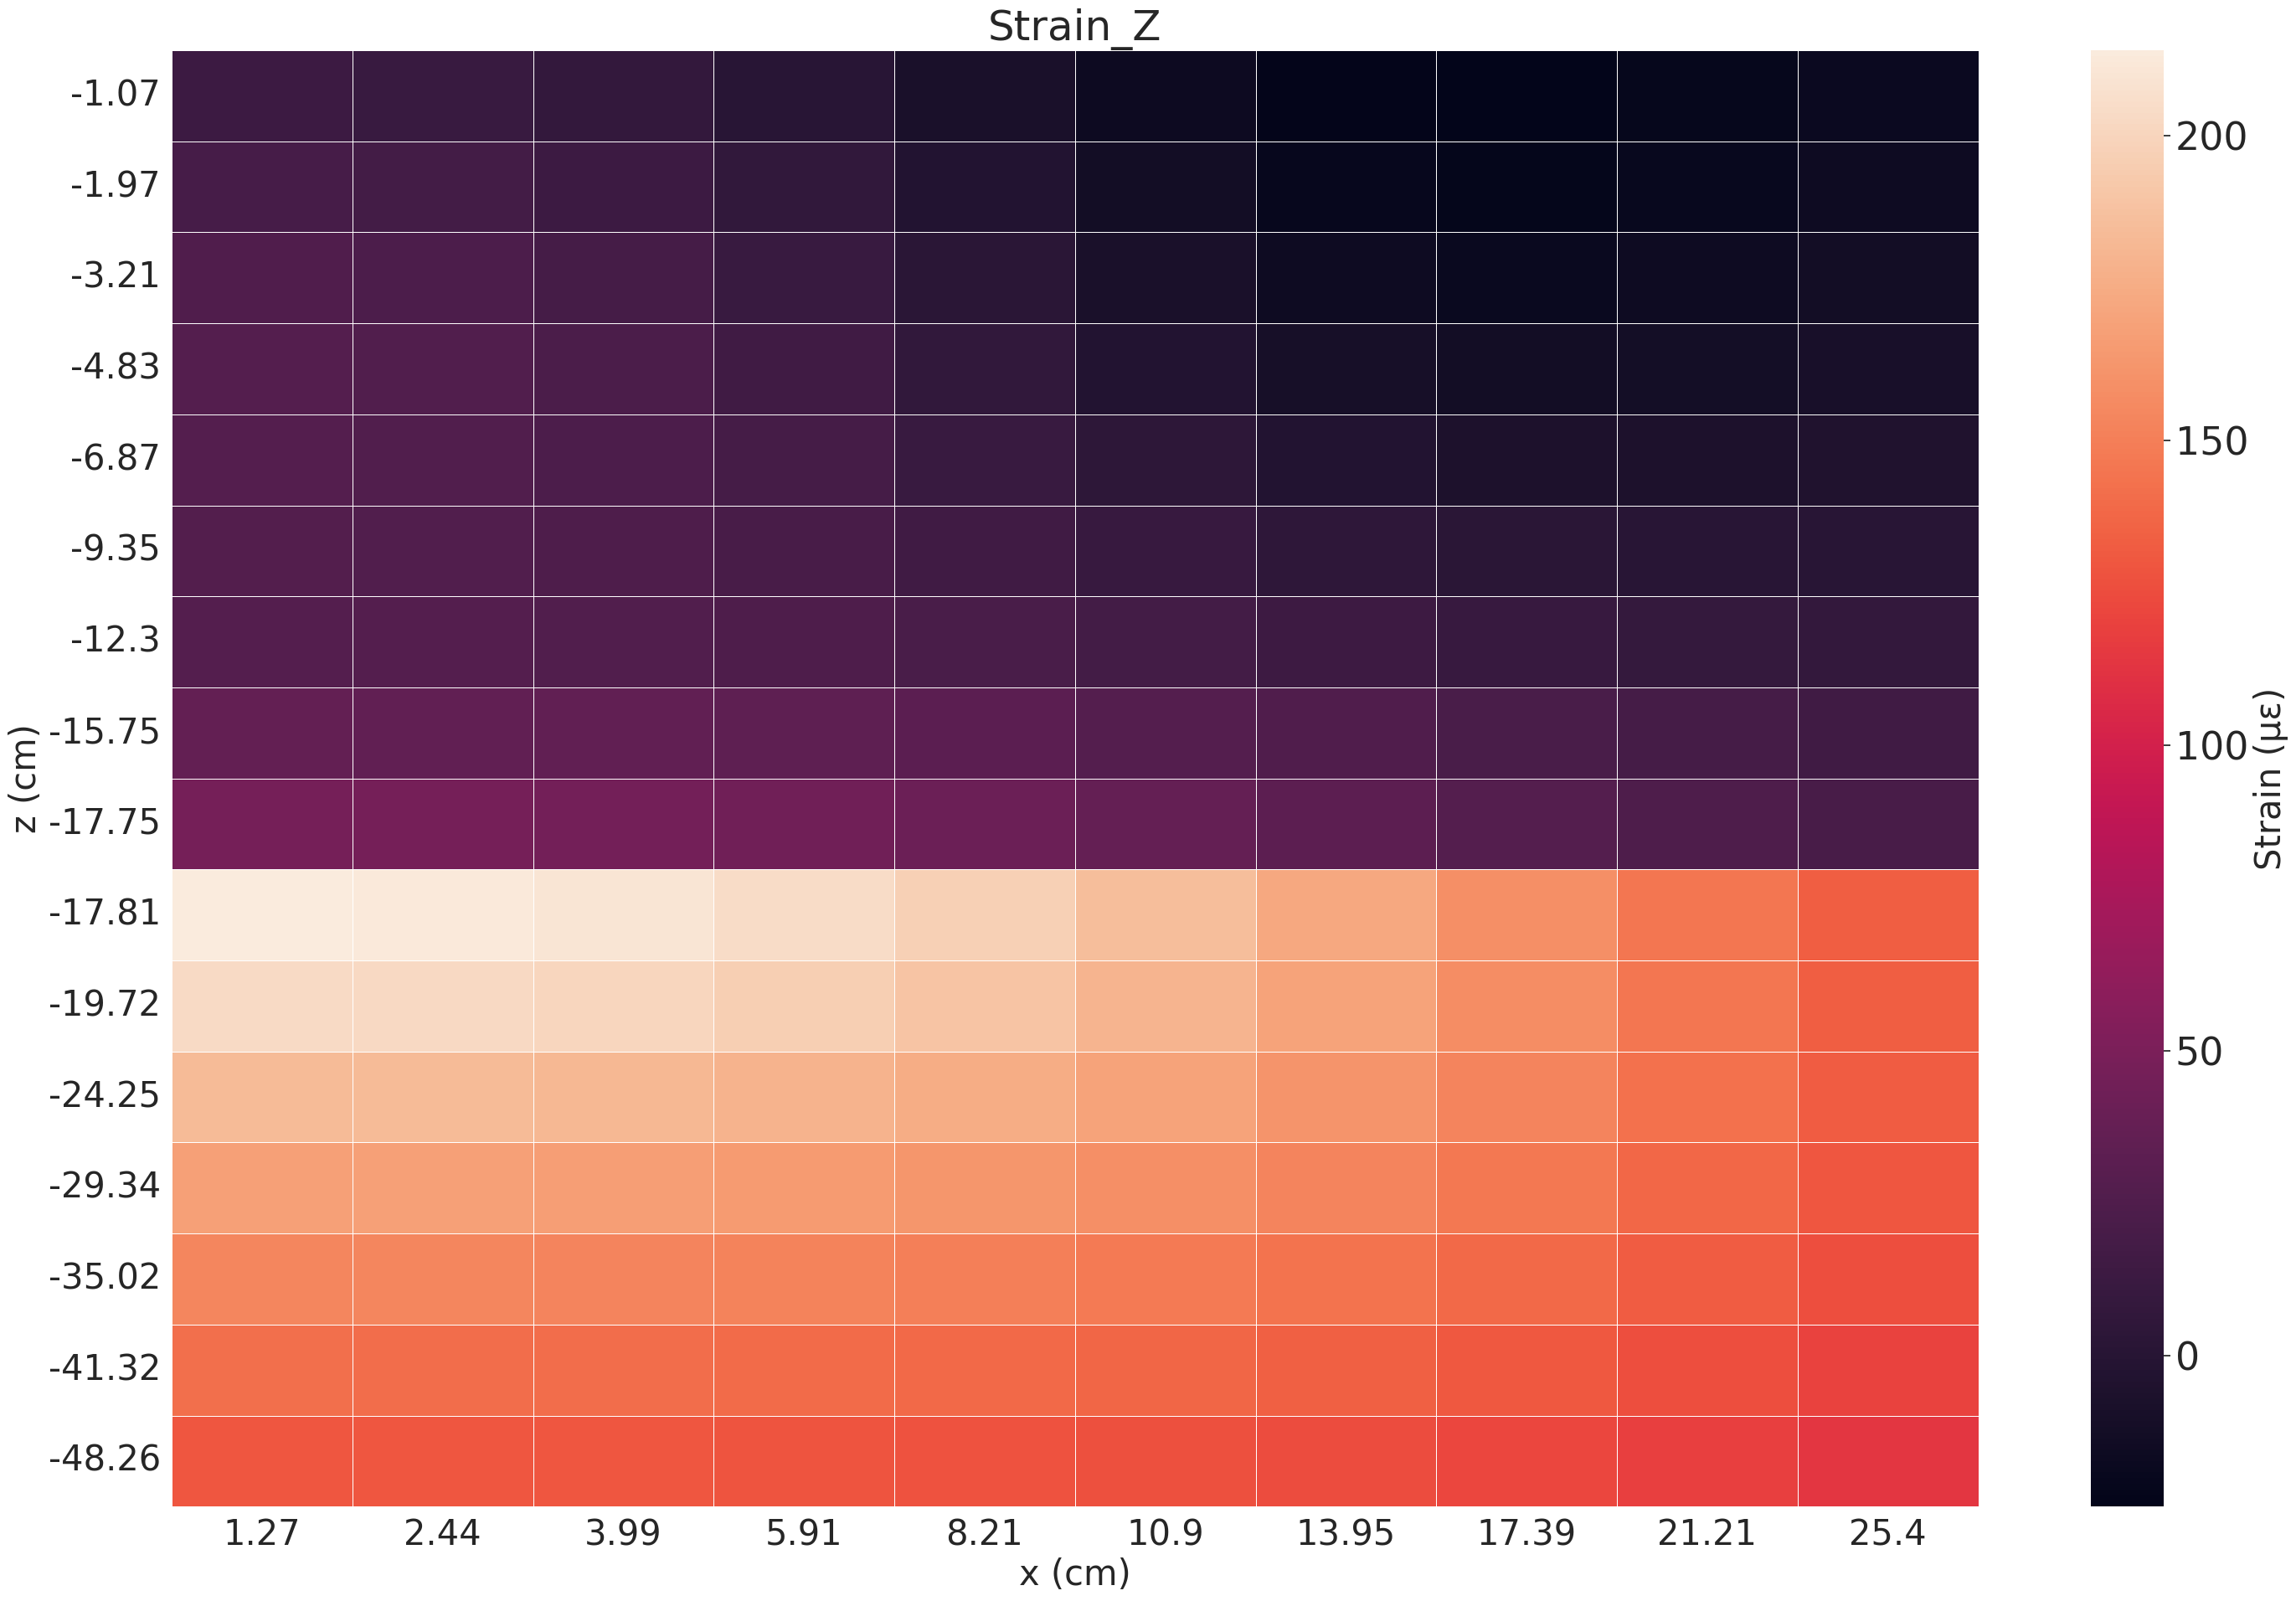

In [ ]:


sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_prep,linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30)
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()
plt.close()

sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_bar=np.reshape(pred_graph[test_struct][:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_bar, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30)
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.title('$\epsilon_z$')
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"NN_strain_z_heatmap_struct0_pred.png"))
plt.close()
